<a href="https://colab.research.google.com/github/A-Burnhard/Seoul-Bike-Sharing-Demand-Analysis/blob/main/Bikes_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

**Dataset**

Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

Source:

Data Source :http://data.seoul.go.kr/
SOUTH KOREA PUBLIC HOLIDAYS. URL: publicholidays.go.kr

In [ ]:
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive//Machine Learning/SeoulBikeData.csv'


In [30]:
dataset_cols = ["bike_count", "hour", "temp", "humidity", "wind", "visibility", "dew_pt_temp", "radiation", "rain", "snow", "functional"]
df = pd.read_csv(file_path,encoding='ISO-8859-1').drop(["Date", "Holiday", "Seasons"], axis=1)


In [35]:
df.columns = dataset_cols
df["functional"] = (df["functional"] == 'Yes').astype(int)
df = df.drop(["hour"], axis=1)

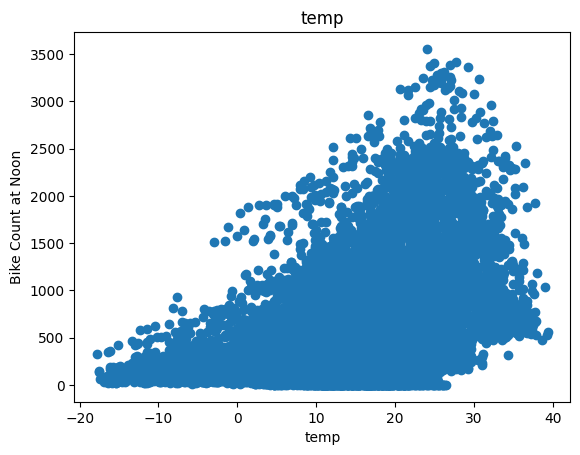

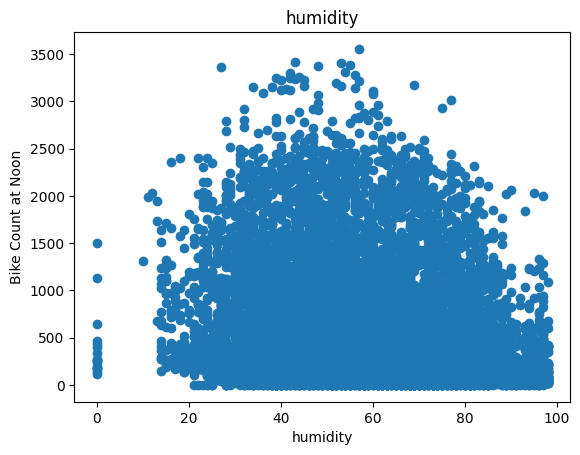

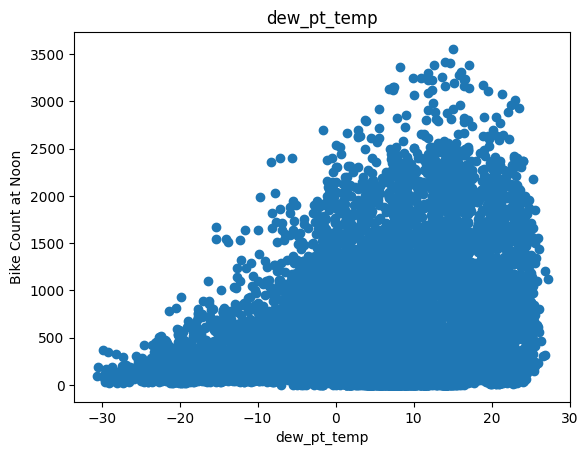

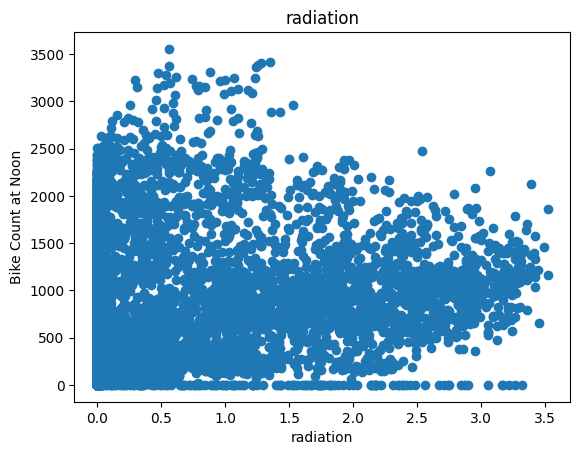

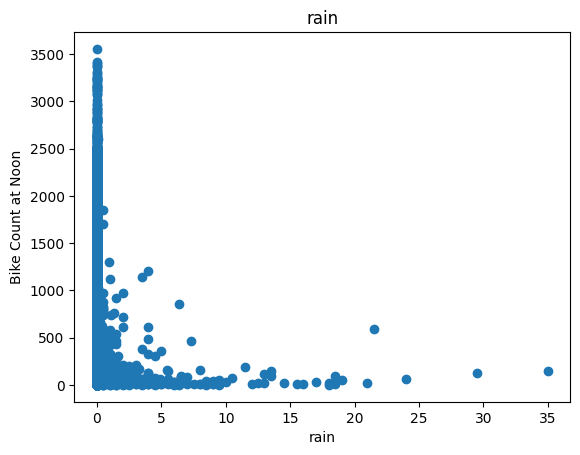

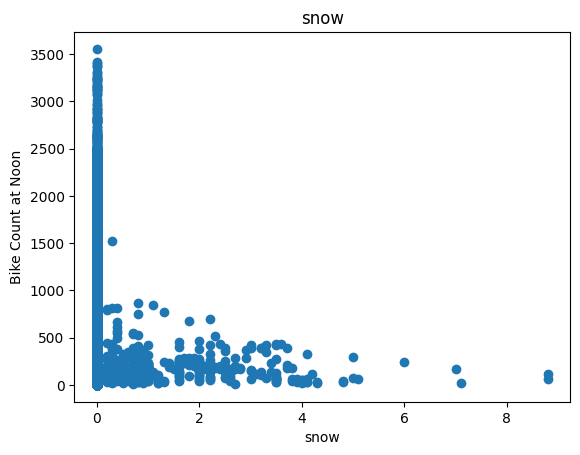

In [37]:
for label in df.columns[1:]:
  plt.scatter(df[label], df["bike_count"])
  plt.title(label)
  plt.ylabel("Bike Count at Noon")
  plt.xlabel(label)
  plt.show()

In [36]:
df = df.drop(["wind", "visibility", "functional"], axis=1)